In [24]:
%run talktools.py

###  Sao Paulo School of Advanced Science on Learning from Data , July 31 - Aug 2, 2019
### Big Data Sets in Astronomy, Zeljko Ivezic, University of Washington
https://github.com/dirac-institute/uw-astr598-w18/tree/master/SPSAS2019/SPSAS2019day3-1.ipynb


# Day 3: Dimensionality reduction, Regression and Time Series Analysis in Astronomy

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
%matplotlib inline

## To warm up, let's see a collection of SDSS spectra of galaxies

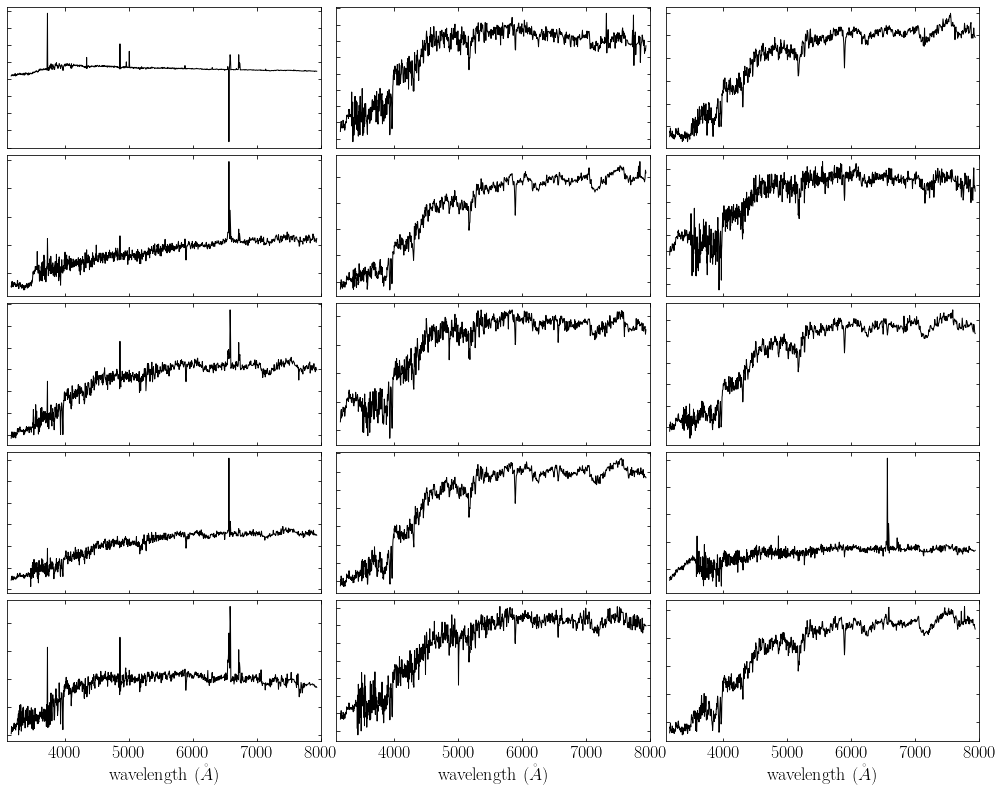

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import sdss_corrected_spectra

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
np.random.seed(5)
nrows = 5
ncols = 3
ind = np.random.randint(spectra.shape[0], size=nrows * ncols)
spec_sample = spectra[ind]

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(15, 12))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(lam, spec_sample[ncols * j + i], '-k', lw=1)
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

## Let's now apply the Principal Component Analysis to these spectra

Each spectrum above has 2048 wavelength bins and the SDSS sample contains about a million such spectra

Let's see if we can describe so many spectra with a much smaller sample of eigen-components, and thus describe each spectrum
with much smaller number of eigen-coefficients than 2048. 

Such desciption would be good for both data compression and physical understanding!

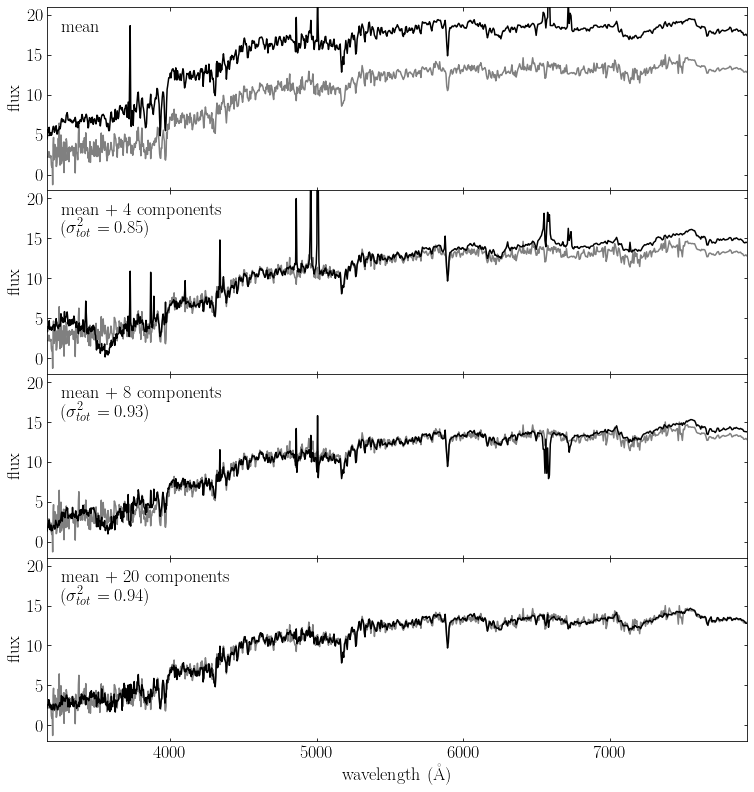

In [8]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)


#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

## And now let's compare PCA, ICA and NMF

For example, we know that galaxy light is an additive combination of spectra that cannot be negative! 


@pickle_results: using precomputed results from 'spec_decompositions.pkl'


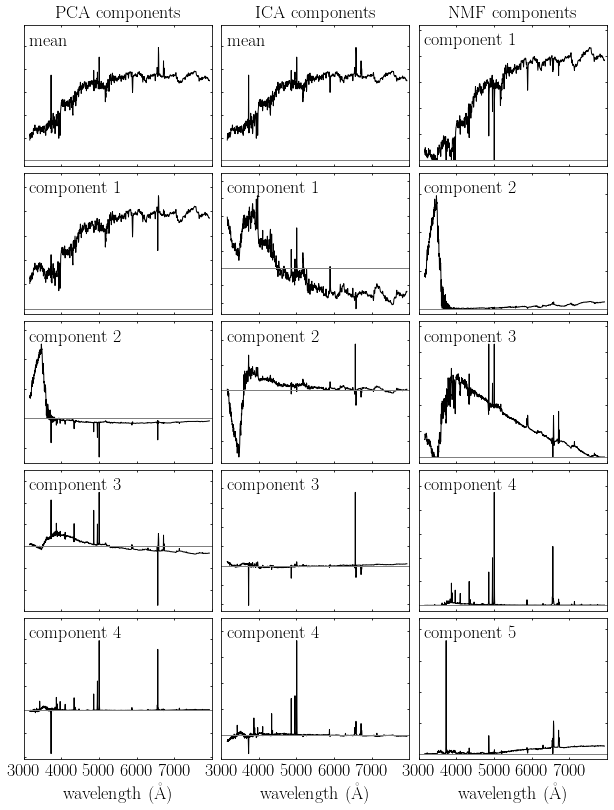

In [10]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF, FastICA, PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)


#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
#  we'll save the results so that they can be re-used
@pickle_results('spec_decompositions.pkl')
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 12))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

 ## Let's have a break!